In [ ]:
# Test that IDE is working perfectly
print("Hello World")

Hello World


**Introduction**

This notebook reproduces—end-to-end—the “Build Your Own Convolutional Neural Network” coral-species classification tutorial from the ML for Life Sciences @ TACC curriculum, but adapts every placeholder and system-specific step to my own environment. The original walkthrough assumes running on TACC’s Frontera via the TACC Analysis Portal (containerized Jupyter kernel, preinstalled CUDA/TensorFlow, and data staged under $SCRATCH). In contrast, I executed the workflow on Google Colab (single T4 GPU, TensorFlow 2.19.0), so I replaced TACC-specific paths and shell commands with Colab-appropriate data handling and verified that all code cells run cleanly in this setting.

Where the tutorial included underscored blanks or elided parameters, I completed them to make the pipeline self-contained: e.g., supplying dataframe=..., x_col, and y_col in flow_from_dataframe(...); setting the input shape to (224, 224, 3) and the output layer to Dense(3, activation='softmax'); enabling stratified train/val/test splits; and wiring in class weights, data augmentation, and callbacks (EarlyStopping, ReduceLROnPlateau). I also adjusted the data-loading strategy: instead of $SCRATCH/tacc-deep-learning-tutorials/data/coral-species, I uploaded coral-species.zip to Colab, unzipped locally, and pointed all generators to those paths. The rest of the pipeline (sanity checks, visualization, scratch CNN training, VGG19 transfer learning, evaluation via confusion matrix and classification report) mirrors the TACC tutorial, allowing direct comparison of outcomes across environments.

In the write-up that follows, I first reference the original TACC steps (their environment, commands, and expected outputs) and then present my Colab run (commands, logs, and plots), highlighting any differences caused by hardware, library versions, or execution context. The result is a portable, reproducible variant of the tutorial that others can run in Colab (or another IDE) without access to TACC, while preserving the scientific intent and evaluation methodology of the original.

**Key adaptations made for Colab**

Environment: TACC container (TensorFlow 2.13.0, multi-GPU) → Colab runtime (TensorFlow 2.19.0, single T4 GPU).

Data access: $SCRATCH/.../coral-species → files.upload() + !unzip coral-species.zip -d coral-species and dataset_dir = Path("coral-species").

Placeholders resolved: completed all flow_from_dataframe(...) arguments; set Input(shape=(224,224,3)); Dense(3, activation='softmax').

Reproducibility: fixed seeds, stratified splits, and consistent shuffle=False for validation/test.

Training/transfer learning: replicated the scratch CNN and VGG19 pipelines with augmentation, class weights, and callbacks, then evaluated with confusion matrix and classification report for apples-to-apples comparison.


**Tutorial Source :** [https://life-sciences-ml-at-tacc.readthedocs.io/en/latest/section3/build_your_own_cnn.html](https:https://life-sciences-ml-at-tacc.readthedocs.io/en/latest/section3/build_your_own_cnn.html//)

**Data Source :** [https://github.com/kbeavers/tacc-deep-learning-tutorials](https://)

In [ ]:
import tensorflow as tf

In [ ]:
#Check if Tensorflow can detect a GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
print(tf.__version__)

2.19.0


In [ ]:
from google.colab import files

# This will open a dialog box for you to select the file from your computer
uploaded = files.upload()


Saving coral-species.zip to coral-species.zip


In [ ]:
!unzip coral-species.zip -d coral-species


Archive:  coral-species.zip
   creating: coral-species/ACER/
  inflating: coral-species/ACER/acropora_174.jpg  
  inflating: coral-species/ACER/acropora_160.jpg  
  inflating: coral-species/ACER/acropora_148.jpg  
  inflating: coral-species/ACER/acropora_014.jpg  
  inflating: coral-species/ACER/acropora_028.jpg  
  inflating: coral-species/ACER/acropora_029.jpg  
  inflating: coral-species/ACER/acropora_015.jpg  
  inflating: coral-species/ACER/acropora_001.jpg  
  inflating: coral-species/ACER/acropora_161.jpg  
  inflating: coral-species/ACER/acropora_017.jpg  
  inflating: coral-species/ACER/acropora_003.jpg  
  inflating: coral-species/ACER/acropora_002.jpg  
  inflating: coral-species/ACER/acropora_016.jpg  
  inflating: coral-species/ACER/acropora_200.jpg  
  inflating: coral-species/ACER/acropora_176.jpg  
  inflating: coral-species/ACER/acropora_166.jpg  
  inflating: coral-species/ACER/acropora_199.jpg  
  inflating: coral-species/ACER/acropora_012.jpg  
  inflating: coral-sp

In [ ]:
from pathlib import Path

dataset_dir = Path("coral-species")

print(list(dataset_dir.iterdir()))


[PosixPath('coral-species/MCAV'), PosixPath('coral-species/ACER'), PosixPath('coral-species/CNAT')]


In [ ]:
# Recursively list all files under the dataset directory
image_files = list(dataset_dir.rglob("*"))

# Extract and print the unique file extensions
# This helps us confirm that only valid image files are present
extensions = set(p.suffix.lower() for p in image_files if p.is_file())
print("File extensions found:", extensions)

File extensions found: {'.jpg'}


In [ ]:
from PIL import Image
from pathlib import Path
from collections import Counter

def explore_image_dataset(dataset_dir):
    """
    Explore basic properties of images: size and color mode.
    """
    print("Starting image dataset exploration...\n")

    # Gather all .jpg files in the dataset
    image_files = list(Path(dataset_dir).rglob('*.jpg'))
    print(f"Found {len(image_files)} image files\n")

    # Track sizes and color modes
    image_sizes = []
    color_modes = []

    print("Checking image dimensions and color modes...\n")
    for img_path in image_files:
        with Image.open(img_path) as img:
            image_sizes.append(img.size)
            color_modes.append(img.mode)

    # Summarize image sizes
    size_counts = Counter(image_sizes)
    print("=== Image Sizes ===")
    print(f"Found {len(size_counts)} unique image sizes:")
    for size, count in size_counts.most_common():
        print(f"- {size}: {count} images")

    # Summarize color modes
    mode_counts = Counter(color_modes)
    print("\n=== Color Modes ===")
    print(f"Found {len(mode_counts)} unique color modes:")
    for mode, count in mode_counts.most_common():
        print(f"- {mode}: {count} images")

    # Simple recommendations
    print("\n=== Recommendations ===")
    if len(size_counts) > 1:
        print(f"Images have different sizes. Consider resizing.")
    else:
        print("All images are the same size.")

    if len(mode_counts) > 1:
        print("Images have different color modes. Consider converting to RGB.")
    else:
        print("All images share the same color mode.")

# Run the function
explore_image_dataset(dataset_dir)

Starting image dataset exploration...

Found 417 image files

Checking image dimensions and color modes...

=== Image Sizes ===
Found 63 unique image sizes:
- (800, 600): 231 images
- (800, 533): 36 images
- (600, 800): 29 images
- (800, 534): 13 images
- (533, 800): 10 images
- (800, 602): 8 images
- (800, 450): 8 images
- (534, 800): 7 images
- (800, 700): 7 images
- (800, 449): 4 images
- (800, 601): 4 images
- (800, 800): 3 images
- (800, 640): 3 images
- (800, 545): 2 images
- (800, 634): 2 images
- (800, 599): 2 images
- (700, 800): 2 images
- (800, 617): 1 images
- (800, 677): 1 images
- (642, 800): 1 images
- (800, 744): 1 images
- (800, 731): 1 images
- (607, 800): 1 images
- (800, 542): 1 images
- (800, 791): 1 images
- (800, 546): 1 images
- (800, 530): 1 images
- (800, 722): 1 images
- (691, 800): 1 images
- (785, 800): 1 images
- (800, 665): 1 images
- (692, 800): 1 images
- (694, 800): 1 images
- (800, 713): 1 images
- (800, 798): 1 images
- (800, 667): 1 images
- (800, 6

In [ ]:
from PIL import Image
from tqdm import tqdm

# Find all .jpg files in the dataset
# NOTE: add the correct file extension(s) for your image dataset in the space indicated below
# TIP: see Step 1.2
image_paths = list(dataset_dir.rglob('*.jpg'))

# Create lists to store valid and corrupted files
valid_images = []
bad_images = []

print("Checking for corrupted images...\n")

# tqdm adds a progress bar to show how long the process will take
for path in tqdm(image_paths):
    try:
        # Try to open and verify the image
        with Image.open(path) as img:
            img.verify()
        # If the image is valid, add it to valid_images
        valid_images.append(path)

    except Exception:
        # If any error occurs while opening/verifying the image, add it to bad_images
        bad_images.append(path)

print(f"Valid images: {len(valid_images)}")
print(f"Corrupted images removed: {len(bad_images)}")

Checking for corrupted images...



100%|██████████| 417/417 [00:00<00:00, 16036.83it/s]

Valid images: 417
Corrupted images removed: 0


In [ ]:
import pandas as pd

# Set pandas to display full column content (no truncation)
pd.set_option('display.max_colwidth', None)

# Build (filepath, label) pairs from valid image paths
data = []
for path in valid_images:
    label = path.parent.name # Extract label from directory name
    data.append((str(path), label))

# Create a DataFrame with columns for filepath and label
df = pd.DataFrame(data, columns=["filepath", "label"])

# Show a preview of the DataFrame
df.head()

filepath label
0  coral-species/MCAV/montastraea_093.jpg  MCAV
1  coral-species/MCAV/montastraea_127.jpg  MCAV
2  coral-species/MCAV/montastraea_037.jpg  MCAV
3  coral-species/MCAV/montastraea_172.jpg  MCAV
4  coral-species/MCAV/montastraea_015.jpg  MCAV

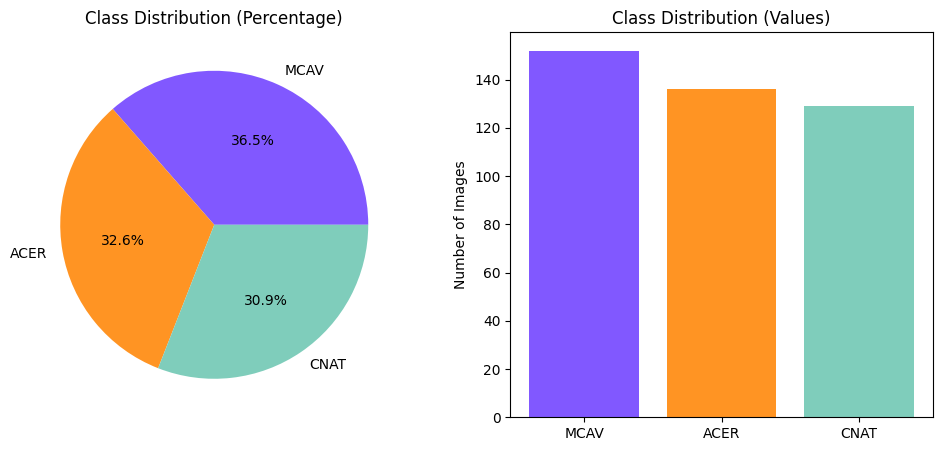

MCAV: 152 images (36.45%)
ACER: 136 images (32.61%)
CNAT: 129 images (30.94%)


In [ ]:
import matplotlib.pyplot as plt

# Count class distribution (counts how many times each unique value appears in the 'label' column of your DataFrame)
counts = df['label'].value_counts()

# Create a figure with two plots side-by-side (1-row, 2-columns; 12 inches wide, 5 inches tall)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Define a color palette
colors = ['#8158ff', '#ff9423', '#7fcdbb']

# Create a Pie chart in the first plot position (axes[0])
## counts.values: The number of images for each class
## counts.index: The class labels (e.g., 'ACER', 'CNAT', 'MCAV')
## autopct='%1.1f%%': Display the percentage of images for each class
## colors: The colors to use for each class (defined earlier)
axes[0].pie(counts.values, labels=counts.index, autopct='%1.1f%%', colors=colors)
axes[0].set_title('Class Distribution (Percentage)')

# Creates a Bar chart in the second plot position (axes[1])
axes[1].bar(counts.index, counts.values, color=colors)
axes[1].set_title('Class Distribution (Values)')
axes[1].set_ylabel('Number of Images')

# Display the figure with both charts
plt.show()

# Print label counts and percentages
for label, count in counts.items():
    print(f"{label}: {count} images ({count/len(df)*100:1.2f}%)")

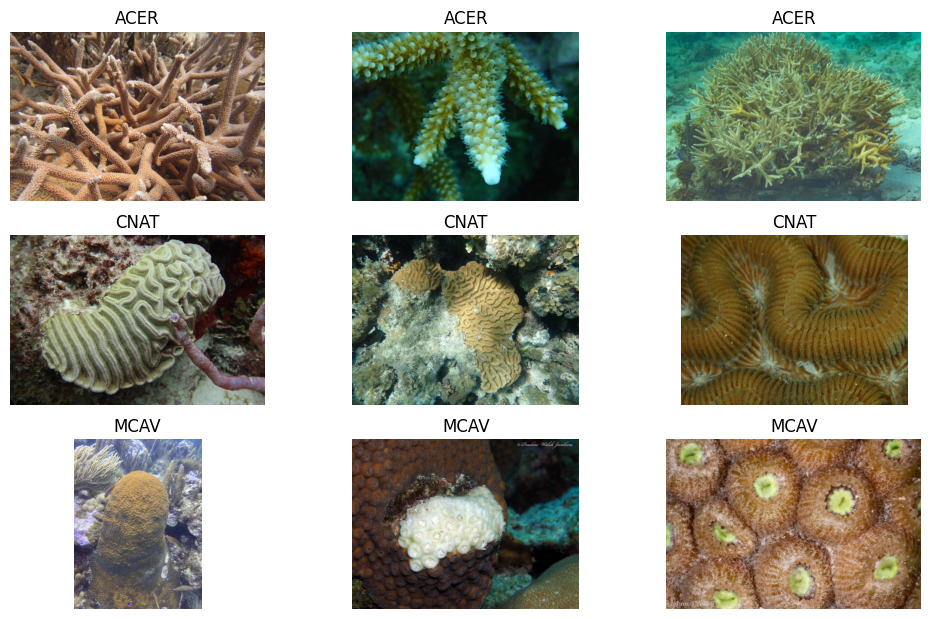

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
import random

# Set the number of images to display per class
samples_per_class = 3

# Get list of unique coral species names (classes)
classes = df['label'].unique()

# Create a figure with appropriate size
# The height (2.5 * len(classes)) ensures enough space for all images
plt.figure(figsize=(12, len(classes) * 2.5))

# Loop through each class to create a grid of images
for i, label in enumerate(sorted(classes)):
    # Filter DataFrame to get only images from the current class
    class_df = df[df['label'] == label]

    # Randomly select 3 images from the current class
    sample_paths = random.sample(list(class_df['filepath']), samples_per_class)

    # Create subplot for each image
    for j, img_path in enumerate(sample_paths):

        # Calculate position in grid: (row * width) + column + 1
        plt.subplot(len(classes), samples_per_class, i * samples_per_class + j + 1)

        # Load and display the image
        img = load_img(img_path)        # Load the image
        plt.imshow(img)                 # Display the image
        plt.title(label)                # Add species name as title
        plt.axis('off')

plt.show()

In [ ]:
# NOTE: Replace the spaces indicated below with your code
from sklearn.model_selection import train_test_split

# First, split the original dataset into training + test sets
train_df, test_df = train_test_split(
    df,                            # This is our DataFrame from step 1.5
    test_size=0.20,                # Keep 20% of the data in the test set
    stratify=df["label"],          # Ensure each split maintains original class distribution
    random_state=123               # Set random seed for reproducibility
)

# Then, split the training set into training + validation sets
train_df, val_df = train_test_split(
  train_df,                          # What goes here?
    test_size=0.20,                # Keep 20% of the training data in the validation set
    stratify=train_df["label"],                 # Ensure each split maintains original class distribution
    random_state=123               # Set random seed for reproducibility
)

# Print split sizes
total = len(df)
print(f"\nDataset splits:")
print(f"Train: {len(train_df)} images ({len(train_df)/total:.2%})")
print(f"Validation: {len(val_df)} images ({len(val_df)/total:.2%})")
print(f"Test: {len(test_df)} images ({len(test_df)/total:.2%})")



Dataset splits:
Train: 266 images (63.79%)
Validation: 67 images (16.07%)
Test: 84 images (20.14%)


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Get unique class labels
class_labels = np.unique(train_df['label'])

# Compute class weights based on training labels
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=class_labels,
    y=train_df['label']
)

# Convert to a dictionary: {index: weight}
class_weight_dict = dict(zip(range(len(class_labels)), class_weights))

# Preview the result
print("Computed class weights:")
for index, weight in class_weight_dict.items():
    print(f"{index}: {weight:.2f}")

Computed class weights:
0: 1.02
1: 1.08
2: 0.91


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define training data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Normalize pixel values to [0, 1]
    rotation_range=30,          # Augment: Random rotation
    width_shift_range=0.2,      # Augment: Random horizontal shift
    height_shift_range=0.2,     # Augment: Random vertical shift
    zoom_range=0.2,             # Augment: Random zoom
    horizontal_flip=True,       # Augment: Random horizontal flip
    fill_mode='nearest'         # Augment: After random transformations, fill in missing pixels with nearest neighbor
)

# Validation and test data generators only need normalization – do not augment
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Set image size and batch size
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Training generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,         # Our training DataFrame
    x_col='filepath',           # Column containing image paths
    y_col='label',              # Column containing labels
    target_size=IMAGE_SIZE,     # Resize images to this size
    batch_size=BATCH_SIZE,      # Number of images per batch
    class_mode='categorical',   # One-hot encode the labels
    color_mode='rgb',           # Use RGB color channels
    shuffle=True,                # Randomize order of images
    seed=123                    # Set random seed for reproducibility
)

# Validation generator
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,            # Validation DataFrame
    x_col='filepath',
    y_col='label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,               # Keep original order for validation
    seed=123                    # Set random seed for reproducibility
)

# Test generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,           # Test DataFrame
    x_col='filepath',
    y_col='label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,               # Keep original order for testing
    seed=123                    # Set random seed for reproducibility
)

Found 266 validated image filenames belonging to 3 classes.
Found 67 validated image filenames belonging to 3 classes.
Found 84 validated image filenames belonging to 3 classes.


In [ ]:
# Get one batch from the training generator
images, labels = next(train_generator)

# Check the shape of the batch
print("Image batch shape:", images.shape)    # Should be (BATCH_SIZE, height, width, channels)
print("Label batch shape:", labels.shape)    # Should be (BATCH_SIZE, num_classes)

# Preview the first 5 label vectors
print("\nFirst 5 labels (one-hot encoded):")
print(labels[:5])

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 3)

First 5 labels (one-hot encoded):
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]]


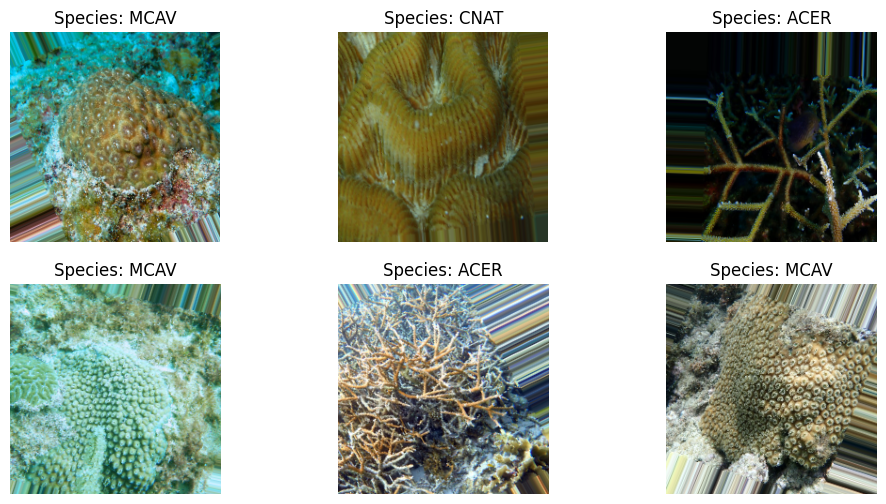

In [ ]:
# Get a fresh batch of images
images, labels = next(train_generator)

# Display 6 images in a grid
plt.figure(figsize=(12, 6))

# Show each image
for i in range(6):
    plt.subplot(2, 3, i + 1)

    # Get the species name
    species_names = list(train_generator.class_indices.keys())
    species = species_names[np.argmax(labels[i])]

    # Show the image
    plt.imshow(images[i])
    plt.title(f"Species: {species}")
    plt.axis("off")

plt.show()

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Conv2D, AveragePooling2D, Flatten, Dense

# Build a custom CNN architecture
cnn_model = Sequential([
    # Input layer: matches image shape (height, width, channels)
    Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),

    # Convolution Block 1
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    AveragePooling2D((2, 2), padding='same'),

    # Convolution Block 2
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    AveragePooling2D((2, 2), padding='same'),

    # Convolution Block 3
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    AveragePooling2D((2, 2), padding='same'),

    # Flatten to convert 2D feature maps into a 1D vector
    Flatten(),

    # Fully connected layers
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(labels.shape[1], activation='softmax')
])

In [ ]:
from tensorflow.keras.optimizers import RMSprop

cnn_model.compile(
    optimizer=RMSprop(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 112, 112, 32)   │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 56, 56, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 28, 28, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,946,883 (49.39 MB)

 Trainable params: 12,946,883 (49.39 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cnn_history = cnn_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    class_weight=class_weight_dict # Computed in Step 3.2
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.2497 - loss: 1.2817 - val_accuracy: 0.3284 - val_loss: 1.0935
Epoch 2/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 462ms/step - accuracy: 0.3600 - loss: 1.0930 - val_accuracy: 0.3881 - val_loss: 1.0900
Epoch 3/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 527ms/step - accuracy: 0.3710 - loss: 1.0875 - val_accuracy: 0.3284 - val_loss: 1.1054
Epoch 4/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 490ms/step - accuracy: 0.3260 - loss: 1.1024 - val_accuracy: 0.3731 - val_loss: 1.0900
Epoch 5/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 649ms/step - accuracy: 0.3887 - loss: 1.0933 - val_accuracy: 0.3433 - val_loss: 1.0962
Epoch 6/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 452ms/step - accuracy: 0.4071 - loss: 1.0729 - val_accuracy: 0.3731 - val_loss: 1.0882
Epoch 7/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 444ms/step - accuracy: 0.4560 - loss: 1.0573 - val_accuracy: 0.3881 - val_loss: 1.0844
Epoch 8/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 564ms/step - accuracy: 0.4830 - loss: 1.0476 - val_accuracy: 0.4179 - val_loss: 1

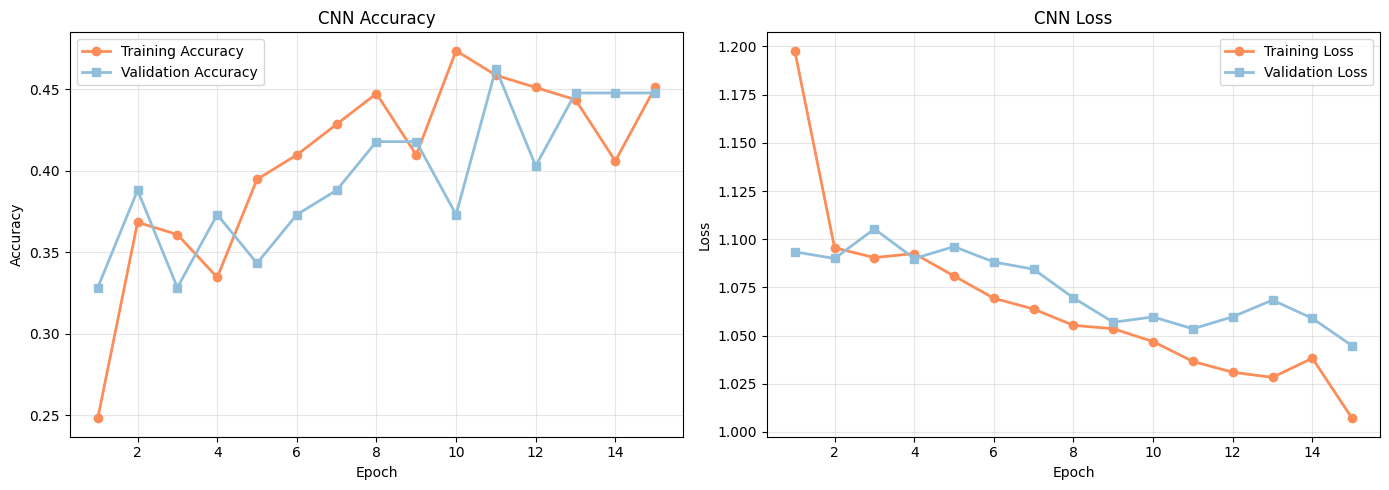

In [ ]:
def plot_training_history(history, title_prefix="CNN"):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Set color palette
    training_color = '#fc8d59'
    validation_color = '#91bfdb'

    # Plot accuracy
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, color=training_color, linestyle='-', marker='o',
            label='Training Accuracy', linewidth=2)
    plt.plot(epochs, val_acc, color=validation_color, linestyle='-', marker='s',
            label='Validation Accuracy', linewidth=2)
    plt.title(f'{title_prefix} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, color=training_color, linestyle='-', marker='o',
            label='Training Loss', linewidth=2)
    plt.plot(epochs, val_loss, color=validation_color, linestyle='-', marker='s',
            label='Validation Loss', linewidth=2)
    plt.title(f'{title_prefix} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_training_history(cnn_history)

In [ ]:
# Evaluate test accuracy and loss
test_loss, test_acc = cnn_model.evaluate(test_generator, verbose=0)
print(f"Test Accuracy: {test_acc:.2%}")
print(f"Test Loss: {test_loss:.4f}")

Test Accuracy: 48.81%
Test Loss: 0.9896


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 354ms/step


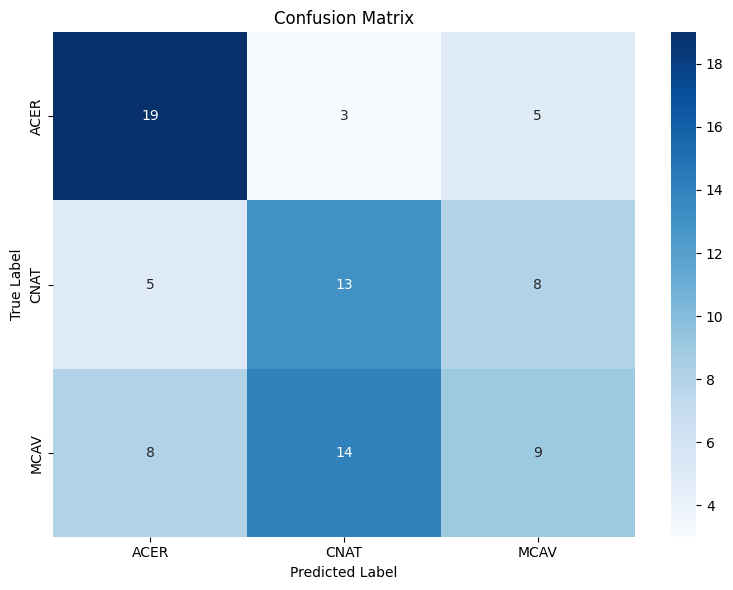

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predicted probabilities for each class
pred_probs = cnn_model.predict(test_generator)

# Convert to predicted class labels
y_pred = np.argmax(pred_probs, axis=1)

# Get true labels
y_true = test_generator.classes

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Map class indices back to names
class_names = list(test_generator.class_indices.keys())

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

        ACER       0.59      0.70      0.64        27
        CNAT       0.43      0.50      0.46        26
        MCAV       0.41      0.29      0.34        31

    accuracy                           0.49        84
   macro avg       0.48      0.50      0.48        84
weighted avg       0.48      0.49      0.48        84



Part 2: Transfer Learning with VGG19

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Constraints
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Define new ImageDataGenerators for VGG19
vgg19_train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

vgg19_val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
vgg19_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
# Assuming train_df, val_df, and test_df are defined
# Create training generator below
train_generator_vgg19 = vgg19_train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    seed=123
)

# Create validation generator below
val_generator_vgg19 = vgg19_val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    seed=123
)

# Create test generator below
test_generator_vgg19 = vgg19_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    seed=123
)

Found 266 validated image filenames belonging to 3 classes.
Found 67 validated image filenames belonging to 3 classes.
Found 84 validated image filenames belonging to 3 classes.


In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout   # Import the necessary layers
from tensorflow.keras.optimizers import RMSprop

# Load VGG19 base (without top classifier)
vgg_base = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg_base.trainable = False  # Freeze all pretrained layers

# Build the full model
VGG19_model = Sequential([
    vgg_base,
    Flatten(),
    Dense(128, activation='relu'),
    #Dropout(0.3),
    Dense(64, activation='relu'),
    #Dropout(0.3),
    Dense(3, activation='softmax')   # 3 coral classes
])

In [ ]:
# Compile with a low learning rate optimizer
VGG19_model.compile(
    optimizer=RMSprop(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',      # Monitor validation accuracy
        patience=5,                  # Number of epochs to wait before stopping
        restore_best_weights=True    # Restore the best weights from the epoch with the highest validation accuracy
    ),
    ReduceLROnPlateau(
        monitor='val_loss',          # Monitor validation loss
        factor=0.5,                  # Reduce learning rate by 50%
        patience=3,                  # Number of epochs to wait before reducing learning rate
        min_lr=1e-6                  # Minimum learning rate
    )
]

# Train the model with callbacks
VGG19_history = VGG19_model.fit(
    train_generator_vgg19,
    validation_data=val_generator_vgg19,
    epochs=15,
    class_weight=class_weight_dict,
    callbacks=callbacks             # Pass the callbacks to the fit method
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.4535 - loss: 4.9190 - val_accuracy: 0.6716 - val_loss: 1.5654 - learning_rate: 1.0000e-04
Epoch 2/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 540ms/step - accuracy: 0.7551 - loss: 0.8923 - val_accuracy: 0.8507 - val_loss: 0.9678 - learning_rate: 1.0000e-04
Epoch 3/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 598ms/step - accuracy: 0.8393 - loss: 0.6809 - val_accuracy: 0.8507 - val_loss: 0.7015 - learning_rate: 1.0000e-04
Epoch 4/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 540ms/step - accuracy: 0.8640 - loss: 0.4551 - val_accuracy: 0.8507 - val_loss: 0.7142 - learning_rate: 1.0000e-04
Epoch 5/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 681ms/step - accuracy: 0.8237 - loss: 0.7448 - val_accuracy: 0.8358 - val_loss: 0.7540 - learning_rate: 1.0000e-04
Epoch 6/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 530ms/step - accuracy: 0.8796 - loss: 0.3952 - val_accuracy: 0.8358 - val_loss: 0.5690 - learning_rate: 1.0000e-04
Epoch 7/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 688ms/step - accuracy: 0.9128 - loss: 0

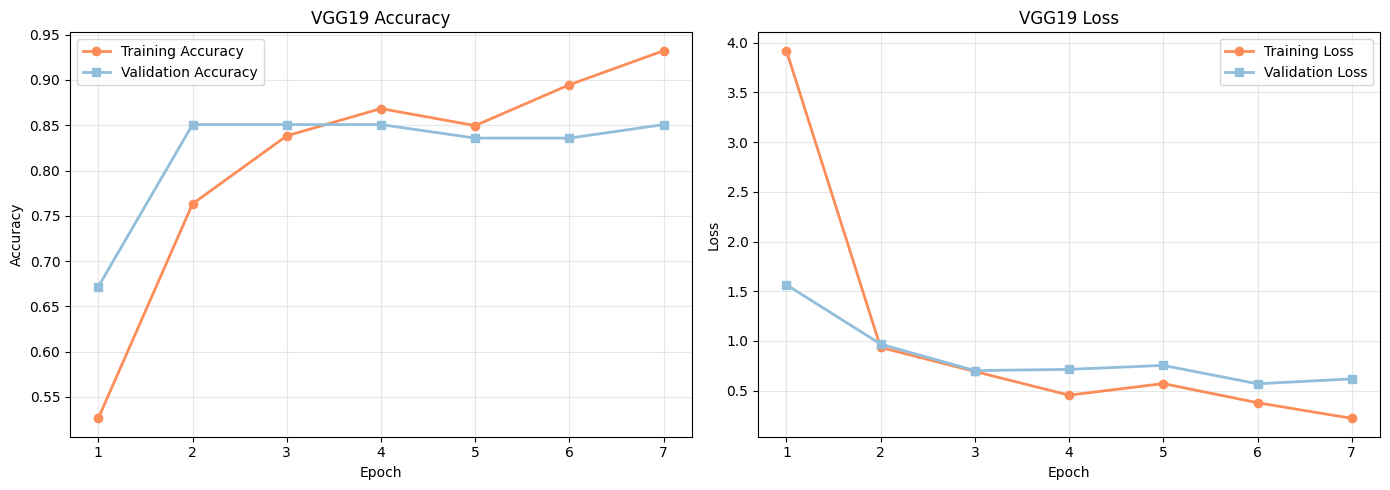

In [ ]:
# Plot for VGG19
plot_training_history(VGG19_history, title_prefix='VGG19')

In [ ]:
# Evaluate test accuracy and loss
# Evaluate test accuracy and loss
test_loss_vgg19, test_acc_vgg19 = VGG19_model.evaluate(test_generator_vgg19, verbose=0)

print(f"Test Accuracy: {test_acc_vgg19:.2%}")
print(f"Test Loss: {test_loss_vgg19:.4f}")


Test Accuracy: 86.90%
Test Loss: 0.5477


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 507ms/step


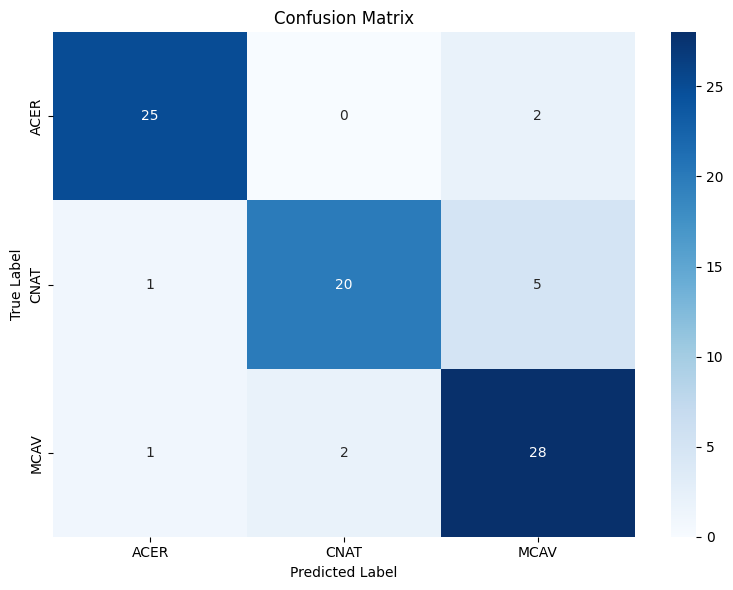

In [ ]:
# Get predicted probabilities for each class
vgg19_pred_probs = VGG19_model.predict(test_generator_vgg19)

# Convert to predicted class labels
vgg19_y_pred = np.argmax(vgg19_pred_probs, axis=1)

# Get true labels
vgg19_y_true = test_generator_vgg19.classes

# Create confusion matrix
cm = confusion_matrix(vgg19_y_true, vgg19_y_pred)

# Map class indices back to names
class_names = list(test_generator_vgg19.class_indices.keys())

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [ ]:
# Print the full classification report
print("Classification Report (VGG19):")
print(classification_report(
    vgg19_y_true,
    vgg19_y_pred,
    target_names=class_names
))

Classification Report (VGG19):
              precision    recall  f1-score   support

        ACER       0.93      0.93      0.93        27
        CNAT       0.91      0.77      0.83        26
        MCAV       0.80      0.90      0.85        31

    accuracy                           0.87        84
   macro avg       0.88      0.87      0.87        84
weighted avg       0.87      0.87      0.87        84



In [ ]:
import os

# Create a mapping from class indices to class names
idx_to_class = {v: k for k, v in test_generator_vgg19.class_indices.items()}

# The filenames already contain the full paths, so we can use them directly
file_paths = test_generator_vgg19.filenames

# Convert class indices to class names
true_class_names = [idx_to_class[idx] for idx in vgg19_y_true]
pred_class_names = [idx_to_class[idx] for idx in vgg19_y_pred]

# Get the confidence scores for the predicted classes
confidence_scores = [vgg19_pred_probs[i][pred_idx] for i, pred_idx in enumerate(vgg19_y_pred)]

# Create the results DataFrame
vgg19_results_df = pd.DataFrame({
    'Filepath': file_paths,
    'True Label': true_class_names,
    'Predicted Label': pred_class_names,
    'Confidence': confidence_scores
})

# Display first few rows
print(vgg19_results_df.head())

                                  Filepath True Label Predicted Label  \
0  coral-species/CNAT/colpophyllia_089.jpg       CNAT            MCAV   
1      coral-species/ACER/acropora_186.jpg       ACER            ACER   
2   coral-species/MCAV/montastraea_075.jpg       MCAV            MCAV   
3  coral-species/CNAT/colpophyllia_075.jpg       CNAT            CNAT   
4   coral-species/MCAV/montastraea_011.jpg       MCAV            CNAT   

   Confidence  
0    0.682669  
1    0.999873  
2    0.999937  
3    0.991909  
4    0.665206  


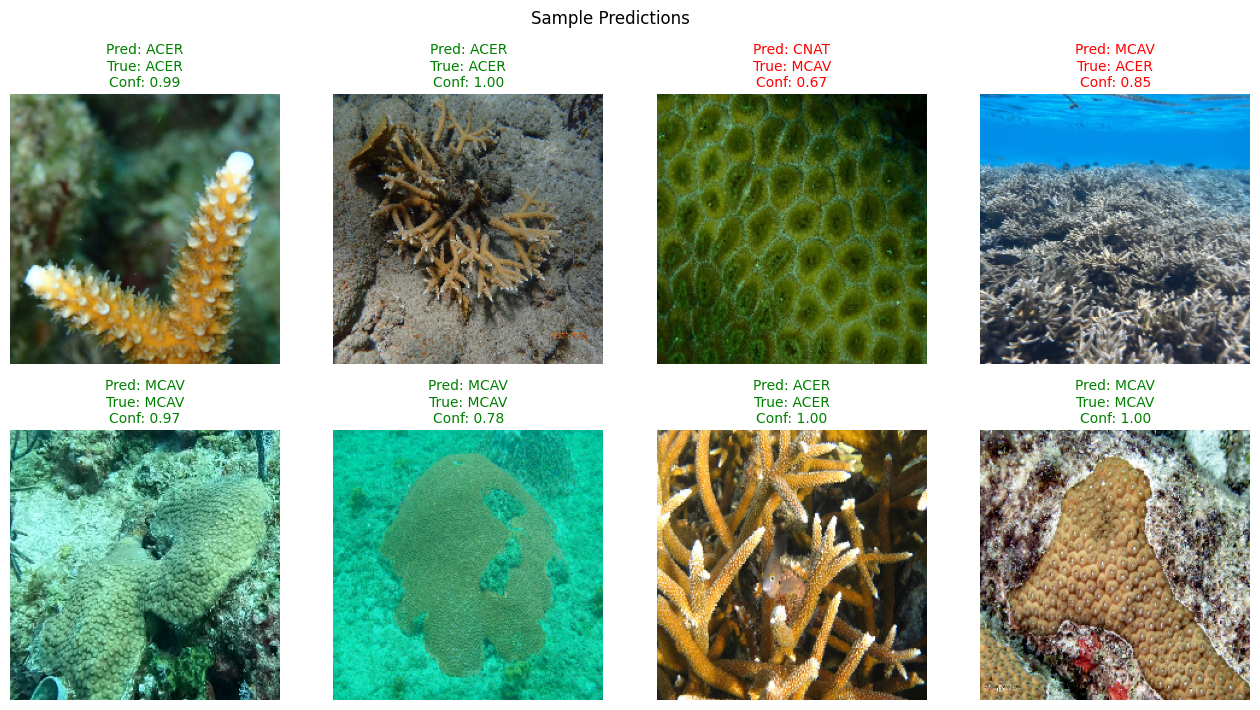

In [ ]:
from tensorflow.keras.preprocessing.image import load_img

# Number of test images to show
num_images = 8

# Sample a few random rows from the test results
sample_df = vgg19_results_df.sample(n=num_images, random_state=123).reset_index(drop=True)

# Set up the plot grid
plt.figure(figsize=(16, 8))
for i in range(num_images):
    row = sample_df.iloc[i]
    img = load_img(row['Filepath'], target_size=(224, 224))

    plt.subplot(2, num_images // 2, i + 1)
    plt.imshow(img)
    plt.axis('off')

    # Determine color based on prediction accuracy
    is_correct = row['Predicted Label'] == row['True Label']
    color = 'green' if is_correct else 'red'

    # Create title with colored text
    title = f"Pred: {row['Predicted Label']}\nTrue: {row['True Label']}\nConf: {row['Confidence']:.2f}"
    plt.title(title, fontsize=10, color=color)

plt.suptitle("Sample Predictions", fontsize=12)
plt.show()